In [1]:
import cPickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pymbar import timeseries
from assaytools import pymcmodels
from assaytools.bindingmodels import TwoComponentBindingModel

from assay_simulator import AssaySimulator 

## Example data

In [2]:
data_file = 'p38-Bosutinib-AB_mcmc-2017-03-24 11:47.pickle'
with open(r'%s'%data_file,'rb') as my_file:
    data = cPickle.load(my_file)

### Example of using AssaySimulator to draw possible fluorescence data

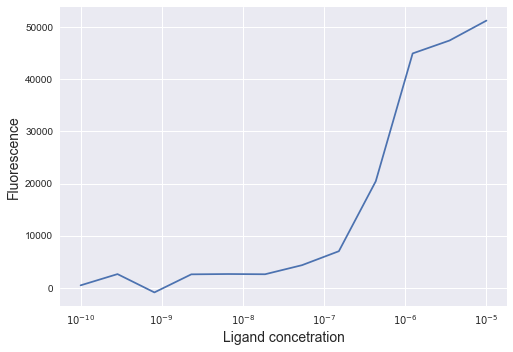

In [3]:
# Ligand and protein concentrations
L_total = 10 ** (np.linspace(-10, -5, num=12))
P_total = 1E-6

# Initialize the class
assay = AssaySimulator(pymc_data=data, L_total=L_total, sample_index=6000, inner_filter=False)

# Draw a possinle
F = assay.simulate_fluorescence(DeltaG=-30, noisy=True)

# Plot
plt.semilogx(L_total, F)
plt.xlabel('Ligand concetration', fontsize=14)
plt.ylabel('Fluorescence', fontsize=14)
plt.show()

## Optimize the protein concentration to minimize variance

Time series analysis on the free energies. Finding the equilibration point and sub sampling the data:

In [4]:
DeltaG_samples = data['DeltaG'][0]
(t_equil, g, N_eff) = timeseries.detectEquilibration(DeltaG_samples, fast=True, nskip=1)

samples_indices = timeseries.subsampleCorrelatedData(DeltaG_samples[t_equil:],g)
mean_DeltaG = np.mean(DeltaG_samples[t_equil:])

 Estimating the coefficient of variation

In [10]:
# The ligand concentrations used in the assay
L_total = 10 ** (np.linspace(-10, -5, num=12))

# The object that will draw fluorescence samples from the pymc assay data

# Number of times the fitting procedure will occur
nposterior_samples = 50  # The number of parameter draws from the posterior
repeats = 10             # The number of repeated fluorescence draws for fixed parameters, but with different noise


# The protein concentrations over which the coefficient of variation will be estimated
P_totals =10 ** (np.linspace(-10, -1, num=20))

CV = []
Bias2 = []
Var = []
# Looping over protein concentrations, drawing from the posterior and fitting the affinity:
for p in range(len(P_totals)):
    estimates = []
    bias_squared = []
    variance = []
    for i in range(nposterior_samples):
        ind = np.random.choice(samples_indices,1)[0]
        simulator = AssaySimulator(pymc_data=data, L_total=L_total, sample_index=ind,  P_total=P_totals[p], inner_filter=True)
        for j in range(repeats):
            fit = simulator.fit_deltaG()
            estimates.append(fit)
            bias_squared.append((fit - simulator.DeltaG)**2)
    bias_squared = np.array(bias_squared)
    Bias2.append(np.mean(bias_squared))
    estimates = np.array(estimates)
    Var.append(np.var(estimates))
    CV.append(np.std(estimates)/np.abs(mean_DeltaG))

CV = np.array(CV)
Bias2 = np.array(Bias2)
Var = np.array(Var)

### Plotting data

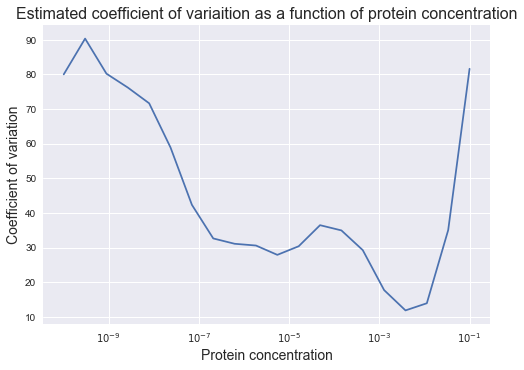

In [11]:
plt.semilogx(P_totals, CV * 100) 
plt.title('Estimated coefficient of variaition as a function of protein concentration', fontsize=16)
plt.xlabel('Protein concentration', fontsize=14)
plt.ylabel('Coefficient of variation', fontsize=14)
plt.show()

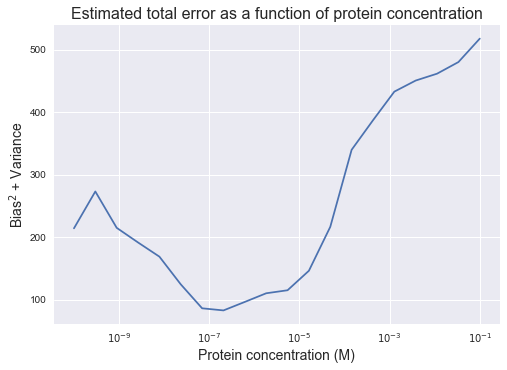

In [12]:
plt.semilogx(P_totals, Bias2 + Var) 
plt.title('Estimated total error as a function of protein concentration', fontsize=16)
plt.xlabel('Protein concentration (M)', fontsize=14)
plt.ylabel('Bias$^2$ + Variance', fontsize=14)
plt.show()

This suggests the protein concentration that produces free energies with the lowest variance is between 1$\mu$M and 10$\mu$M.

### Scrap used when developing AssaySimulator
**DEVELOPMENT ONLY**

In [20]:
#Fmodel_i = IF_i[:]*(F_PL*PL_i + F_L*L_i + F_P*P_i + F_buffer*path_length) + IF_i_plate*F_plate

# Draw Kd
# Predict free protein, free ligand and complex concentrations
# Find the factors that map concentrations to fluorescence for each (at the same index of the draw)
# Extract the buffer fluorescence and noise (Gaussian?)

# Scan different protein concetrations and predict the variance (or coefficient of variation?)

# Repeat!

def simulate_fluorescence(L_total, P_total, data, ind, inner_filter=False, geometry='top', assay_volume=100E-6, well_area=0.3969):
    """
    Predict the fluorescence of the complex using AssayTools posterior for a given protein concentration
    and range of ligand concentrations.
    """
    # Non-pymc paramters
    path_length = assay_volume * 1000 / well_area
    
    # Unpack the pymc parameters for a given MCMC iteration index.
    DeltaG = data['DeltaG'][0][ind]    
    epsilon_em = data['epsilon_em'][0][ind]
    epsilon_ex = data['epsilon_ex'][0][ind]
    F_buffer = data['F_buffer'][0][ind]
    F_plate = data['F_plate'][0][ind]
    F_PL = data['F_PL'][0][ind]
    F_L = data['F_L'][0][ind]
    F_P = data['F_P'][0][ind]
    
    # Select the parameters for the noise based on where the fluorescence was taken
    if geometry == 'top':
        sigma = data['sigma_top'][0][ind]
    else:
        sigma = data['sigma_bottom'][0][ind]
        
    # Predict the concentrations of the complex, free protein and free ligand 
    [P_free, L_free, PL] = TwoComponentBindingModel.equilibrium_concentrations(DeltaG, P_total, L_total)
    
    # Predict fluorescence
    if inner_filter:
        IF_i = pymcmodels.inner_filter_effect_attenuation(epsilon_ex, epsilon_em, path_length, L_total, geometry)
        IF_i_plate = np.exp(-epsilon_ex * path_length * L_total)
        Fmodel = IF_i * (F_PL * PL + F_L * L_free + F_P * P_free + F_buffer * path_length) + IF_i_plate * F_plate
        #Fmodel += np.random.lognormal(mean=0.0, sigma=log_sigma, size=len(L_total))
        Fmodel += np.random.normal(loc=0.0, scale=sigma, size=len(L_total))
    else:
        #Fmodel = F_PL * PL + F_L * L_free + F_P * P_free + F_buffer * path_length
        #Fmodel += np.random.normal(loc=0.0, scale=sigma, size=len(L_total))
        Fmodel = F_PL * PL
  
    return Fmodel

def fit_affinity(fluorescence, L_total, P_total, F_PL, F_L, F_P, ):
    pass

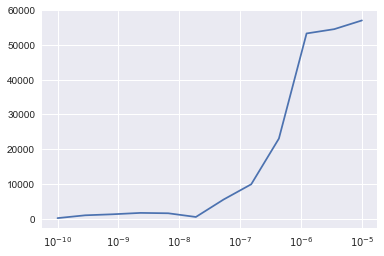

In [21]:
L_total = 10 ** (np.linspace(-10, -5, num=12))
P_total = 1E-6
F = simulate_fluorescence(L_total, P_total, data=data, ind=5000, inner_filter=True)

plt.semilogx(L_total, F)
plt.show()

In [83]:
np.random.normal?

In [70]:
log_sigma = data['log_sigma_top'][0][6000]

In [58]:
data['precision_top'][0].mean()

9.4616644832502051e-07

In [53]:
np.exp(-14.8)

3.7362993798852602e-07

In [61]:
data['sigma_top'][0].mean()

1103.7680422909621

In [91]:
import pymc

In [105]:

pymc.Normal?